In [64]:
filepath = '/fileshare/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
srate = 240 # Hz
# Filtered 0.1 - 60Hz

In [12]:
import mne
from scipy.io import loadmat
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
eeg_data = loadmat(filepath)

In [8]:
eeg_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])

In [9]:
eeg_data['Signal'].shape

(85, 7794, 64)

In [10]:
eeg_data['Flashing'].shape

(85, 7794)

In [11]:
eeg_data['StimulusType'].shape

(85, 7794)

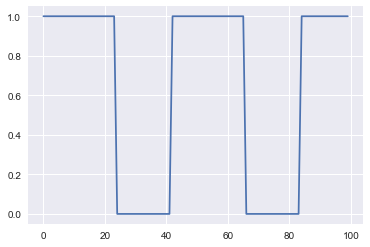

In [23]:
plt.plot(eeg_data['Flashing'][0, :100])

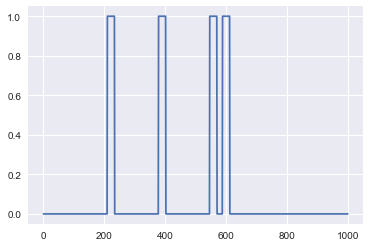

In [16]:
plt.plot(eeg_data['StimulusType'][0, :1000])

In [25]:
import numpy as np
import pandas as pd

In [26]:
flash_series = pd.Series(eeg_data['Flashing'][0, :])

In [27]:
flash_series.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float32

In [28]:
diff_seq = flash_series.diff()

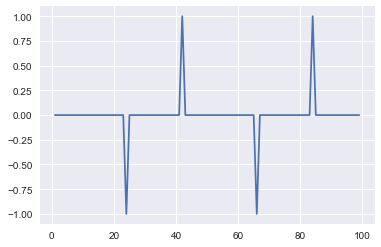

In [30]:
plt.plot(diff_seq[:100])

In [36]:
stimtype_series = pd.Series(eeg_data['StimulusType'][0, :])

In [44]:
# First event will be missing so fill with 1
event_df = pd.DataFrame({'flash_onset':diff_seq.fillna(1), 'stim_type': eeg_data['StimulusType'][0, :]})

In [49]:
np.round(0.8 * 240)

192.0

In [150]:
def create_event_frame(flash_series, stimtype_series):
    diff_seq = flash_series.diff()
    # First event will be missing so fill with 1
    return pd.DataFrame({'flash_onset':diff_seq.fillna(1), 
                         'stim_type': stimtype_series})


In [151]:
def epoch_generator(eeg_data, event_df, duration=0.8, srate=240):
    """ Yields epoch as well as classification label
    """
    offset = int(np.round(duration * srate))
    for idx in event_df[event_df['flash_onset']==1].index:
        data = eeg_data[idx:idx+offset, :] - eeg_data[idx, :] # Removing offset
        yield data, event_df['stim_type'].at[idx]

In [152]:
def dataset_epoch_generator(filename, srate=240):
    dataset_dict = loadmat(filename)
    num_runs = dataset_dict['Flashing'].shape[0]
    
    for run in range(num_runs):
        eeg_array = dataset_dict['Signal'][run,:,:]
        flash_series = pd.Series(dataset_dict['Flashing'][run, :])
        stimtype_series = pd.Series(dataset_dict['StimulusType'][run, :])
        event_df = create_event_frame(flash_series, stimtype_series)
        # Transforming from time by channel to channel by time
        eeg_array = mne.filter.filter_data(eeg_array.astype(np.float64).T, srate, None, 18, verbose=False).T
        for epoch in epoch_generator(eeg_array, event_df, duration=0.8, srate=srate):
            yield epoch

In [153]:
egen = dataset_epoch_generator(filepath, srate=srate)

In [154]:
pos_epochs_gen = filter(lambda x: x[1]==1, egen)

In [155]:
pos_data=[epoch for epoch, label in pos_epochs_gen]

In [156]:
data_array = np.array(pos_data)

In [157]:
d_mean = data_array.mean(axis=0)

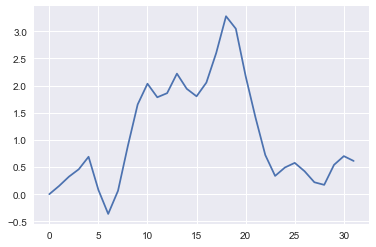

In [165]:
plt.plot(d_mean[::6,11])

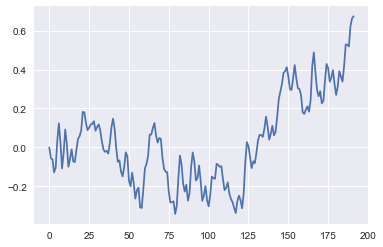

In [94]:
neg_epochs_gen = filter(lambda x: x[1]==0, egen)
neg_data=[epoch for epoch, label in neg_epochs_gen]
data_array = np.array(neg_data)
d_mean = data_array.mean(axis=0)
plt.plot(d_mean[:,19])